# Kimura 2-Parameter Model  
Nucleotide substitution model with same probabilities for transitions of $\mathcal{S}$ = $\{$A, G, C, T$\}$ and parameter inference for trees with backwards filtering following https://arxiv.org/abs/2203.04155.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
print(sys.executable)

from jax.random import PRNGKey, split
import hyperiax
import jax
from jax import numpy as jnp
from hyperiax.tree import HypTree, TreeNode
from hyperiax.tree.childrenlist import ChildList
from hyperiax.execution import LevelwiseTreeExecutor
from hyperiax.models import UpLambda
from hyperiax.models.functional import product_fuse_children
from hyperiax.mcmc import Parameter, ParameterStore, UniformParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.plotting import trace_plots

import matplotlib.pyplot as plt
from tqdm import tqdm

import math
import numpy as np
from Bio import Phylo
from io import StringIO
from functools import reduce

/Users/sara/anaconda3/envs/hyperiax/bin/python


In [3]:
key = PRNGKey(42)

In [4]:
# Updated Uniform Parameter Class
class UniformParameter(Parameter):
    def __init__(self, value, min=0., max=1., keep_constant=False) -> None:
        super().__init__(value)
        self.min = min
        self.max = max
        self.keep_constant = keep_constant

    def propose(self, key):
        if self.keep_constant:
            return self

        return UniformParameter(jax.random.uniform(key, minval=self.min, maxval=self.max), self.min, self.max,
                                self.keep_constant)

    def update(self, value, accepted):
        if accepted:
            self.value = value

    def log_prior(self):
        return 0.

Kimura 2-parameters kernel function 

In [5]:
def kimura2_matrix(alpha, beta):
    """
    Generates the Kimura 2-Parameter transition matrix for given alpha and beta values.

    Assume:
     i) transitions (A <-> G and C <-> T) have rate alpha,
     ii) transversions (A <-> C, A <-> T, G <-> C, G <-> T) have rate beta.

    Input:
        alpha: The rate of transitions.
        beta: The rate of transversions.

    Output:
        matrix: Kimura 2-Parameter transition matrix.
    """

    # Conditions
    if alpha < 0 or beta < 0 or (alpha + 2*beta) > 1:
        raise ValueError("Alpha and Beta don't follow conditions")

    # 4x4 Transition matrix
    matrix = np.array([[1 - alpha - 2 * beta, alpha, beta, beta],
                      [alpha, 1 - alpha - 2 * beta, beta, beta],
                      [beta, beta, 1 - alpha - 2 * beta, alpha],
                      [beta, beta, alpha, 1 - alpha - 2 * beta]])

    # Probability Matrix rows check
    if not np.allclose(np.sum(matrix, axis=1), 1):
        raise ValueError("The rows are not equal to 1")

    return matrix

# Tree Set Up
First, we initialize the tree with for each node the type, value, and log_sum (norm).

Tree: HypTree with 5 levels and 16 nodes


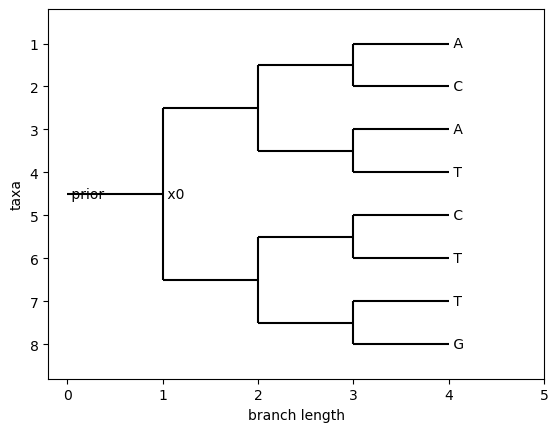

In [6]:
# Initial Newick Tree
newick_string = "(((A,C), (A,T)), ((C, T), (T, G)));"
tree_newick = hyperiax.tree.builders.tree_from_newick(newick_string)
# newick = Phylo.read(StringIO(newick_string), "newick")

# For random symmetric trees 
# tree_symm = hyperiax.tree.builders.symmetric_tree(h=5, degree=2)

# Prior Node
prior = TreeNode(); prior.name = "prior"

# Root Node
x0 = tree_newick.root; x0.name = "x0"
x0.parent = prior; prior.children = ChildList([x0])
x0.children = tree_newick.root.children

# Create the tree
tree = HypTree(prior)
print('Tree:', tree)

# types and initialize log sum to zero
troot = 0; tinner_node = 1; tleaf_node = 2

for i in tree.iter_bfs():
    i['type'] = tinner_node
    i['log_sum'] = 0

for i in tree.iter_leaves():
    i['type'] = tleaf_node

tree.root['type'] = troot
x0['type'] = troot
  
# number of states
R = 4

# root value
tree.root['value'] = jnp.zeros(R)

# observations, if none then create random observations 
nucleotides = ['A', 'G', 'C', 'T']
for i in tree.iter_leaves():
    if i.name in nucleotides:
        i['value'] = jnp.eye(R)[nucleotides.index(i.name)]
    else:
        i['value'] = jnp.eye(R)[np.random.choice(4)]
        i.name = nucleotides[jnp.argmax(i['value'])]

# Save tree figure 
Phylo.draw(Phylo.read(StringIO(tree.to_newick()), "newick"), branch_labels=lambda c: c.branch_length, do_show=False)
plt.savefig('K_Tree.png')

# Name hidden states with numbers
for i, node in enumerate(tree.iter_bfs(), start=-1):
    node.name = f'x_{i}' if node.name is None else f'{node.name}'

# prior kernel
pi1 = 0.9; pi2 = 0.08; pi3 = 0.01; pi4 = 0.01
km10 = lambda params: jnp.diag([pi1, pi2, pi3, pi4])

# inner node kernel
kst = lambda params: kimura2_matrix(params['alpha'], params['beta'])

# leaves kernel
lambdi = lambda params: jnp.eye(R)

# transition function for each kernel
def transition(value, type, params):
    return jax.lax.cond(type == tinner_node,
                        lambda: jnp.dot(kst(params), value),
                        lambda: jax.lax.cond(type == tleaf_node,
                                             lambda: jnp.dot(kst(params), jnp.dot(lambdi(params), value)),
                                             lambda: jnp.array([pi1, pi2, pi3, pi4])
                                            )
                       )

Parameters for the kimura transition kernel.

In [7]:
# parameters, alpha with uniform prior
params = ParameterStore({
    'alpha': UniformParameter(value=.05),  # alpha parameter for kst (Kimura)
    'beta': UniformParameter(value=.15),   # beta parameter for kst (Kimura)
})

# Save true params for later use
true_params = ParameterStore({
    'alpha': UniformParameter(value=.05), 
    'beta': UniformParameter(value=.15),   
})

We now define the backwards filter through the up and fuse functions. In this case, the up operation is first a matrix multiplication and then a dot product of the children.

In [8]:
# backwards filter with normalized product
def up(value, type, params, **args):
    return jax.vmap(lambda value, type: {'value': transition(value, type, params)})(value, type)

def norm_product_fuse(**kwargs):
    value = reduce(lambda x, y: x * y, kwargs['child_value']).reshape(-1)
    new_value = value / jnp.linalg.norm(value)
    log_sum = math.log(jnp.linalg.norm(value))
    return {'value': new_value, 'log_sum': log_sum}

We create the model and executor for the backwards filter (up) with the normalized product of the values after joining them.

In [9]:
# create model and executor
save_tree = tree.copy()
upmodel = UpLambda(up_fn=up, fuse_fn=norm_product_fuse)
upexec = LevelwiseTreeExecutor(upmodel)

In [10]:
# execture backwards filter
utree = upexec.up(tree, params.values())

# It also normalizes the prior which I avoid
utree.root.data['log_sum'] = 0
utree.root.data['value'] = jnp.array([pi1, pi2, pi3, pi4])

# print results
total_log_sum = 0
for node in utree.iter_bfs():
    # print(node.name)
    print(node.data)
    total_log_sum += node.data['log_sum']
    

{'type': 0, 'log_sum': 0, 'value': Array([0.9 , 0.08, 0.01, 0.01], dtype=float32)}
{'type': 0, 'log_sum': -1.0951989004641007, 'value': Array([0.6185585 , 0.32203987, 0.32726595, 0.6376305 ], dtype=float32)}
{'type': 1, 'log_sum': -1.0093095497920384, 'value': Array([0.90671396, 0.09328599, 0.29083276, 0.29083282], dtype=float32)}
{'type': 1, 'log_sum': -0.8648523405059749, 'value': Array([0.19973549, 0.6227047 , 0.23106651, 0.7203839 ], dtype=float32)}
{'type': 1, 'log_sum': -1.9783793771074984, 'value': Array([0.70502394, 0.05423261, 0.70502394, 0.05423261], dtype=float32)}
{'type': 1, 'log_sum': -1.9783793771074984, 'value': Array([0.70502394, 0.05423261, 0.05423261, 0.70502394], dtype=float32)}
{'type': 1, 'log_sum': -2.884160509870688, 'value': Array([0.40249225, 0.40249225, 0.5813777 , 0.5813777 ], dtype=float32)}
{'type': 1, 'log_sum': -1.9783793771074984, 'value': Array([0.05423261, 0.70502394, 0.05423261, 0.70502394], dtype=float32)}
{'type': 2, 'log_sum': 0, 'value': Array([1

# Likelihood Computation
We compute the likelihood as the dot product of the prior kernel and the value at the root, plus the norms of the normalized values.

In [11]:
# Compute Log-Likelihood
prior_vec = utree.root.data['value']
h0_vec = utree.root.children[0].data['value']

log_lik = math.log(jnp.dot(prior_vec, h0_vec)) + total_log_sum
print(f"The log-likelihoog is {log_lik}")

The log-likelihoog is -12.312714064841247


# Parameters Comparation
Contour plot of log-likelihood results for different combinations of alpha and beta

In [12]:
alpha_range = np.linspace(0.02, 0.32, 50)
beta_range = np.linspace(0.02, 0.32, 50)
likelihoods = np.zeros((len(alpha_range), len(beta_range)))

for i, new_alpha in enumerate(alpha_range):
    for j, new_beta in enumerate(beta_range):
        # Update alpha
        params['alpha'].update(float(new_alpha), True)
        params['beta'].update(float(new_beta), True)

        # create model and executor
        upmodel = UpLambda(up_fn=up, fuse_fn=norm_product_fuse)
        upexec = LevelwiseTreeExecutor(upmodel)

        # execture backwards filter
        new_tree = upexec.up(tree, params.values())

        # It also normalizes the prior right now so
        new_tree.root.data['log_sum'] = 0

        # print results
        total_log_sum = 0
        for node in utree.iter_bfs():
            total_log_sum += node.data['log_sum']
            
        # Compute Log-Likelihood
        h0_vec = new_tree.root.children[0].data['value']
        new_lik = math.log(jnp.dot(prior_vec, h0_vec)) + total_log_sum
        likelihoods[i, j] = new_lik

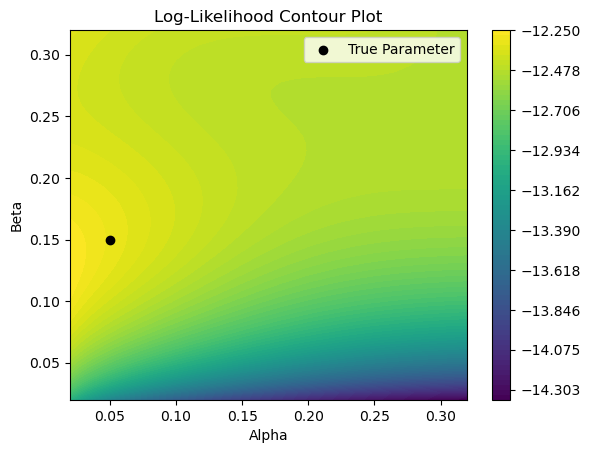

In [13]:
alpha_grid, beta_grid = np.meshgrid(alpha_range, beta_range)

plt.figure()
levels = np.linspace(np.min(likelihoods), np.max(likelihoods), 75)
cp = plt.contourf(alpha_grid, beta_grid, likelihoods.T, cmap='viridis', levels=levels)
plt.colorbar(cp)

# Plot the chosen parameters
plt.scatter(true_params['alpha'].value, true_params['beta'].value, color='black', label='True Parameter')
plt.legend()

plt.xlabel('Alpha')
plt.ylabel('Beta')
plt.title('Log-Likelihood Contour Plot')
plt.savefig("K2_Contour.png")
plt.show()